## Imports


In [1]:
import numpy as np
import cv2
import open3d as o3d
import os
import matplotlib.pyplot as plt
import random

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
PATH = os.path.join(os.getcwd(), os.pardir, 'data', 'CV-A2-calibration')

image_filenames = os.listdir(os.path.join(PATH, 'camera_images'))

images = image_filenames #[:25]
camera_images = []
camera_parameters = []
lidar_scans = []

for image in images:
    camera_images.append(os.path.join(PATH, 'camera_images', image))
    camera_parameters.append(os.path.join(PATH, 'camera_parameters', image))
    lidar_scans.append(os.path.join(PATH, 'lidar_scans', image[:-5] + '.pcd'))

## Part 1

In [3]:
# This code is used to detect the plane normal and offset of the chessboard plane in a given point cloud.
# The plane normal is detected by using the SVD method. 
# The plane offset is then calculated by taking the dot product of the plane normal and the mean of the point cloud.

lidar_normals = []

for filename in lidar_scans:

    pcd = o3d.io.read_point_cloud(filename)
    points = np.asarray(pcd.points)

    centroid = np.mean(points, axis=0)
    points_centered = points - centroid
    _, _, V = np.linalg.svd(points_centered)
    plane_normal = V[-1]

    plane_offset = -np.dot(plane_normal, np.mean(points, axis=0))
    lidar_normals.append(plane_normal)

    print(f"Chessboard plane normal for {os.path.basename(filename)}: {plane_normal}")
    print(f"Chessboard plane offset for {os.path.basename(filename)}: {plane_offset}")
    print()

Chessboard plane normal for frame_1061.pcd: [ 0.63693437 -0.76499839  0.09535237]
Chessboard plane offset for frame_1061.pcd: -4.993811298096004

Chessboard plane normal for frame_1075.pcd: [ 0.70169742 -0.70118932  0.1263102 ]
Chessboard plane offset for frame_1075.pcd: -4.720779659728761

Chessboard plane normal for frame_1093.pcd: [ 0.93809241 -0.22958973  0.25936688]
Chessboard plane offset for frame_1093.pcd: -5.204305546806318

Chessboard plane normal for frame_1139.pcd: [ 0.72352642 -0.68812782 -0.05467752]
Chessboard plane offset for frame_1139.pcd: -4.7935016262124694

Chessboard plane normal for frame_1153.pcd: [ 0.83333533 -0.55208241  0.02751785]
Chessboard plane offset for frame_1153.pcd: -5.220803337324184

Chessboard plane normal for frame_1163.pcd: [ 0.91935323 -0.3607026   0.15710911]
Chessboard plane offset for frame_1163.pcd: -5.70252457528633

Chessboard plane normal for frame_1195.pcd: [0.94151039 0.18949708 0.27865578]
Chessboard plane offset for frame_1195.pcd: -

## Part 3

In [4]:
camera_normals = []
rotation_vectors = []
translation_vectors = []

def get_params(name, list):
    for filename in camera_parameters:
        normals = os.path.join(filename, f'{name}')
        with open(normals, 'rb') as f:
            data = f.read()
            data = data.splitlines()
            data = [float(i) for i in data]
            data = np.array(data)
            list.append(data)

    return list

camera_normals = get_params('camera_normals.txt', camera_normals)
rotation_vectors = get_params('rotation_vectors.txt', rotation_vectors)
translation_vectors = get_params('translation_vectors.txt', translation_vectors)

In [5]:
# This is the code for the function euler_rodrigues
# It returns the transformation matrix, C_T_L, and the rotation matrix, C_R_L, 
# which are used to convert a point from the lidar frame to the camera frame.

def euler_rodrigues(n_C, n_L, t, r):

    axis = np.cross(n_C, n_L)
    cos_angle = np.dot(n_C, n_L)
    sin_angle = np.sqrt(1 - cos_angle**2)
    
    K = np.array([[0, -axis[2], axis[1]],
                  [axis[2], 0, -axis[0]],
                  [-axis[1], axis[0], 0]])
    R = np.eye(3) + sin_angle*K + (1 - cos_angle)*np.dot(K, K)

    translation = t - np.dot(R, r)

    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = translation
    return T, R

transformation_matrices = []
rotation_matrices = []
for i in range(len(camera_normals)):
    C_T_L, C_R_L = euler_rodrigues(camera_normals[i], lidar_normals[i], translation_vectors[i], rotation_vectors[i])
    transformation_matrices.append(C_T_L)
    rotation_matrices.append(C_R_L)

## Part 4

In [ ]:
camera_matrix = np.array([[6.353664855742439386e+02, 0.000000000000000000e+00, 6.433965876009681324e+02],
                          [0.000000000000000000e+00, 6.261901730718112731e+02, 3.880747880982142988e+02],
                          [0.000000000000000000e+00, 0.000000000000000000e+00, 1.000000000000000000e+00]])

dist_coeffs = np.array([-8.680180305386757389e-02, 1.156287377058448779e-01, 7.226010587794677240e-03, -2.233537197226079284e-04, -5.891062411595048703e-02])

def project_points(points, C_T_L, rvecs, tvecs, camera_matrix, dist_coeffs):
    
    # Transform points from LIDAR frame to camera frame
    points_camera = np.dot(C_T_L, np.hstack((points, np.ones((points.shape[0], 1)))).T)[:3]
    
    image_points, _ = cv2.projectPoints(points_camera.T, rvecs, tvecs, camera_matrix, dist_coeffs)
    image_points = np.squeeze(image_points)
    
    return image_points

# Iterate through all PCD files and project LIDAR points onto the image plane
for i in range(len(lidar_scans)):
    pcd = o3d.io.read_point_cloud(lidar_scans[i])
    points = np.asarray(pcd.points)
    
    image_points = project_points(points, transformation_matrices[i], rotation_vectors[i], translation_vectors[i], camera_matrix, dist_coeffs)

    image = cv2.imread(camera_images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.scatter(image_points[:, 0], image_points[:, 1], s=1, c='r')
    plt.show()

## Part 5

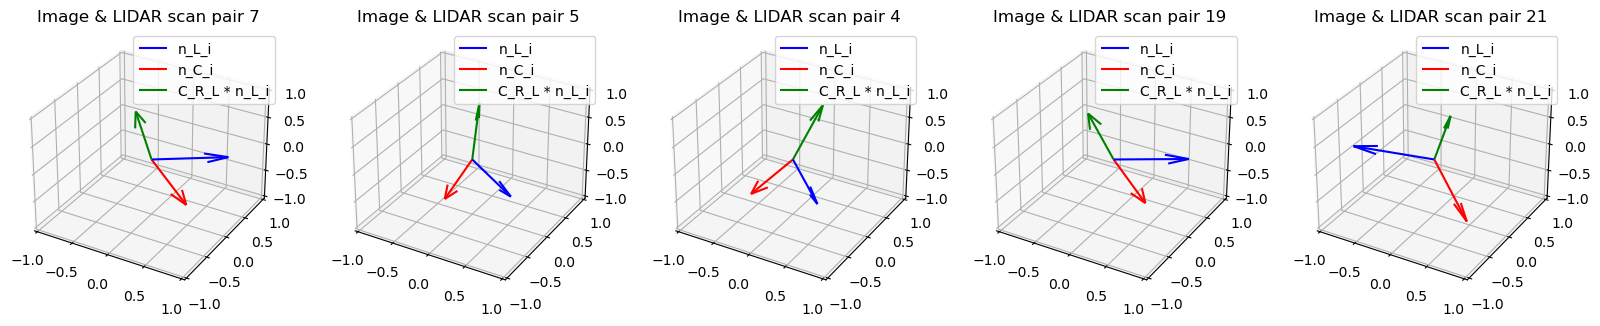

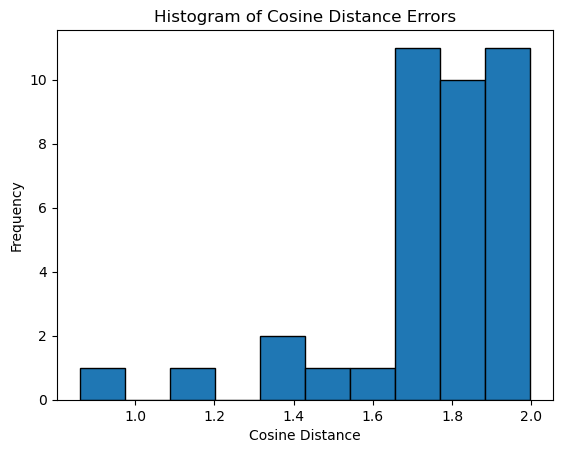

Average error: 1.764549713674732
Standard deviation: 0.23775774942151728


In [8]:
# This code plots 5 random pairs of LIDAR scan and image, and plots the corresponding normals for each pair.
# The normals are plotted in the camera coordinate frame, as well as the LIDAR coordinate frame.
# The blue and red vectors represent the normals in the LIDAR and camera coordinate frame, respectively.
# The green vector represents the camera coordinate frame rotated by the rotation matrix, and then multiplied by the LIDAR normal.
# The cosine distance between the camera normal and the rotated LIDAR normal is calculated and printed.

def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

selected_indices = random.sample(range(25), 5)

fig, axes = plt.subplots(1, 5, subplot_kw={'projection': '3d'}, figsize=(20, 5))

for i, idx in enumerate(selected_indices):
    n_L = lidar_normals[idx]
    n_C = camera_normals[idx]
    n_C_transformed = np.dot(rotation_matrices[idx], n_L)
    
    axes[i].quiver(0, 0, 0, n_L[0], n_L[1], n_L[2], color='b', label='n_L_i')
    axes[i].quiver(0, 0, 0, n_C[0], n_C[1], n_C[2], color='r', label='n_C_i')
    axes[i].quiver(0, 0, 0, n_C_transformed[0], n_C_transformed[1], n_C_transformed[2], color='g', label='C_R_L * n_L_i')
    axes[i].legend()
    axes[i].set_title(f'Image & LIDAR scan pair {idx + 1}')
    axes[i].set_xlim(-1, 1)
    axes[i].set_ylim(-1, 1)
    axes[i].set_zlim(-1, 1)

plt.show()

# Compute the cosine distance between n_C_i and C_R_L * n_L_i for the image and LIDAR scan pairs
cosine_distances = []
for i in range(len(lidar_normals)):
    n_L = lidar_normals[i]
    n_C = camera_normals[i]
    n_C_transformed = np.dot(rotation_matrices[i], n_L)
    cosine_distances.append(cosine_distance(n_C, n_C_transformed))

plt.hist(cosine_distances, bins=10, edgecolor='black')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Distance Errors')
plt.show()

avg_error = np.mean(cosine_distances)
std_dev = np.std(cosine_distances)
print(f"Average error: {avg_error}\nStandard deviation: {std_dev}")